In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as M
from torchvision import transforms

from torch.utils.data import DataLoader

import numpy as np

from PIL import Image
import IPython.display as ipd

In [2]:
CUDA_VISIBLE_DEVICES = 5
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [3]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        
        self.gen = nn.Sequential(
            self._block(z_dim, features_g*16, 4, 1, 0),
            self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1),
            self._block(features_g*4, features_g*2, 4, 2, 1),
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding,
                      bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(0.2)
        )
    
    def forward(self, x):
        return self.gen(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1),
            self._block(features_d*2, features_d*4, 4, 2, 1),
            self._block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding,
                      bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x):
        return self.disc(x)

In [6]:
def test():
    bs, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((bs, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((bs, z_dim, 1, 1))
    disc(gen(z))
    print('success')

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LR = 2e-4
BS = 128
IMG_SIZE = 64
CH = 1

Z_DIM = 100

EPOCHS = 5

FEATURES_DISC, FEATURES_GEN = 64, 64

In [8]:
transform = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CH)], [0.5 for _ in range(CH)]
        )
    ]
)

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
loader = DataLoader(dataset, batch_size=BS, shuffle=True)
gen = Generator(Z_DIM, CH, FEATURES_GEN).to(device)
disc = Discriminator(CH, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LR, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LR, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

gen.train()
disc.train()
print()

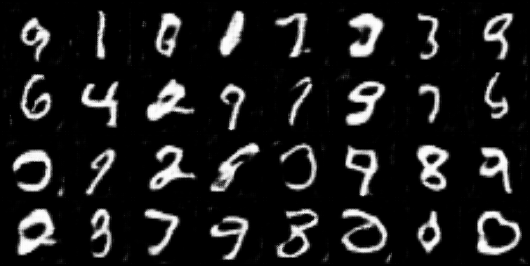

In [9]:
for epoch in range(EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        noise = torch.randn((BS, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)
        
        disc_real = disc(real).reshape(-1) #N
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()
        
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        with torch.no_grad():
            fake = gen(fixed_noise)

            img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
            img_grid_fake *= 255
            ipd.display(Image.fromarray(np.einsum('ijk->jki', img_grid_fake.cpu().numpy().astype(np.uint8))))
            ipd.clear_output(wait=True)